# Inference and Gender Gaps

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
gss = pd.read_hdf('gss_feminism_2022.hdf', key='gss')

Here are the 10 `fe` variables and the text of the questions.

`fechld` 

> A. A working mother can establish just as warm and secure a relationship with her children as a mother who does not work.

`fefam`

> D. It is much better for everyone involved if the man is the achiever outside the home and the woman takes care of the home and family.

`fehelp`

> B. It is more important for a wife to help her husband's career than to have one herself.

`fehire`

> Because of past discrimination, employers should make special efforts to hire and promote qualified women.

`fehome`

> Women should take care of running their homes and leave running the country up to men.

`fejobaff`

> Some people say that because of past discrimination, women should be given preference in hiring and promotion. Others say that such preference in hiring and promotion of women is wrong because it discriminates against men. What about your opinion - are you for or against preferential hiring and promotion of women?
IF FOR:Do you favor preference in hiring and promotion strongly or not strongly?
IF AGAINST:Do you oppose preference in hiring and promotion strongly or not strongly?

`fepol`

> A. Tell me if you agree or disagree with this statement:  Most men are better suited emotionally for politics than are most women.

`fepres`

> If your party nominated a woman for President, would you vote for her if she were qualified for the job?

`fepresch`

> C. A preschool child is likely to suffer if his or her mother works.

`fework`

> Do you approve or disapprove of a married woman earning money in business or industry if she has a husband capable of supporting her?


In [3]:
fe_columns = [x for x in gss.columns if x.startswith('fe')]
fe_columns

['fechld',
 'fefam',
 'fehelp',
 'fehire',
 'fehome',
 'fejobaff',
 'fepol',
 'fepres',
 'fepresch',
 'fework']

In [4]:
from utils import decorate

grouped = gss.groupby('year')
intervals = pd.DataFrame(columns=['first', 'last', '# years'], dtype=int)

for column in fe_columns:
    counts = grouped[column].count()
    nonzero = counts.replace(0, np.nan).dropna()
    n_years = len(nonzero)
    first, last = nonzero.index.min(), nonzero.index.max()
    intervals.loc[column] = first, last, n_years

In [5]:
intervals

,first,last,# years
fechld,1977,2022,23
fefam,1977,2022,23
fehelp,1977,1998,11
fehire,1996,2022,13
fehome,1974,1998,16
fejobaff,1996,2022,13
fepol,1974,2022,27
fepres,1972,2010,19
fepresch,1977,2022,23
fework,1972,1998,17


For each variable, I'll select "agree" and "strongly agree", except for `fework`, where I've selected "approve".

In [6]:
agree_responses = {
    'fechld': [1, 2],
    'fefam': [1, 2],
    'fehelp': [1, 2],
    'fehire': [1, 2],
    'fehome': [1],
    'fejobaff': [1, 2],
    'fepol': [1],
    'fepres': [1],
    'fepresch': [1, 2],
    'fework': [1],
}

## Resampling

`resample_by_year` uses weighted bootstrap resampling to simultaneously correct for stratified sampling and estimate error bounds on a year-by year basis.

In [7]:
from utils import resample_by_year

samples = [resample_by_year(gss, "wtssall") for i in range(101)]

In [8]:
def make_series(data, query, column):
    subset = data.query(query)
    xtab = pd.crosstab(subset['year'], subset[column], normalize='index')
    series = xtab[agree_responses[column]].sum(axis=1)
    return series * 100

`plot_percentiles` plots the median of the resampled estimates as a line and a 90% confidence interval as a shaded area.

In [9]:
def percentile_rows(series_seq, ps):
    """Computes percentiles from aligned series.

    series_seq: list of sequences
    ps: cumulative probabilities

    returns: Series of x-values, NumPy array with selected rows
    """
    df = pd.concat(series_seq, axis=1).dropna()
    xs = df.index
    array = df.values.transpose()
    array = np.sort(array, axis=0)
    nrows, _ = array.shape

    ps = np.asarray(ps)
    indices = (ps * nrows).astype(int)
    rows = array[indices]
    return xs, rows

In [10]:
def plot_percentiles(series_seq, ps=None, label=None, **options):
    """Plot the low, median, and high percentiles.

    series_seq: sequence of Series
    ps: percentiles to use for low, medium and high
    label: string label for the median line
    options: options passed plt.plot and plt.fill_between
    """
    if ps is None:
        ps = [0.05, 0.5, 0.95]
    assert len(ps) == 3

    xs, rows = percentile_rows(series_seq, ps)
    low, med, high = rows
    plt.plot(xs, med, alpha=0.5, label=label, **options)
    plt.fill_between(xs, low, high, linewidth=0, alpha=0.2, **options)

In [11]:
def plot_series_bounds(column, query1, query2):
    male_series_seq = [make_series(sample, query1, column) 
                       for sample in samples]
    female_series_seq = [make_series(sample, query2, column) 
                         for sample in samples]
    plot_percentiles(male_series_seq, label='male')
    plot_percentiles(female_series_seq, label='female')
    decorate(ylabel='Percent agree/approve', 
             xlim=[1971, 2023],
             title=column)

## All respondents

Because the sample sizes are large, the confidence intervals are generally small.

But the variation from year to year is pretty noisy -- it's hard to believe beliefs and attitudes actually change that much. This is a general pattern in GSS and similar datasets. I have not seen people discuss it. My best guess is that the answers get moved around by short-term period effects, like whatever is being discussed in the media during the observation period.

Anyway, some observations:

* Some questions show non-negligible gender gaps, but several of them have none.

* No evidence of long-term expansion of gender gaps -- in fact, a few have converged.

* A couple of questions show a possible expansion in the 2021 and 2022 surveys, but several of the questions in 2021 are weird enough that I have doubts about their validity -- especially fehire.

* The two questions where there might be something happening are `fehire` and `fejobaff` -- exactly the places where there might be something legitimate to disagree about.

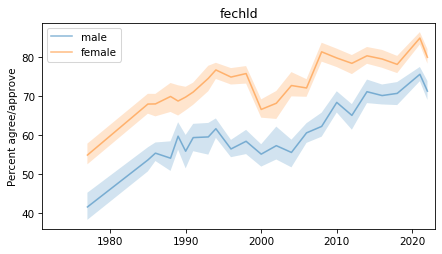

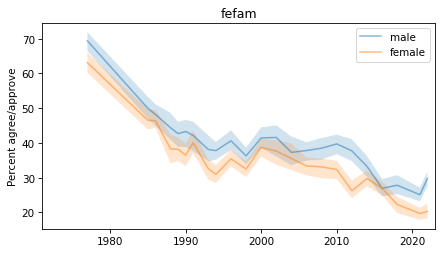

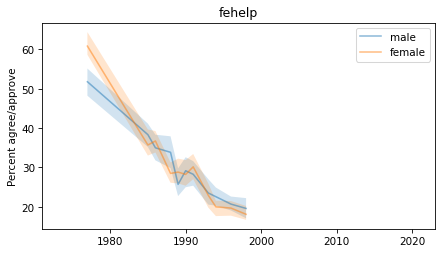

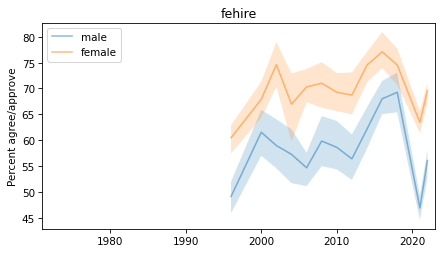

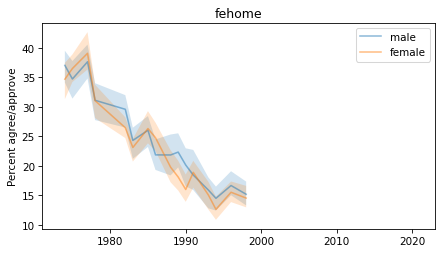

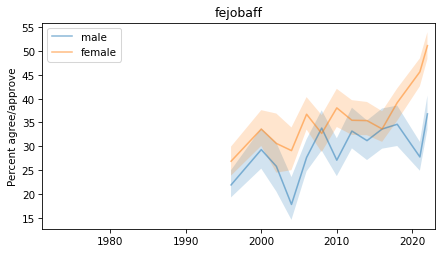

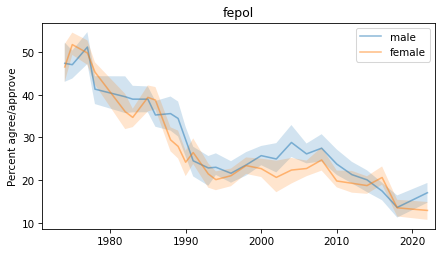

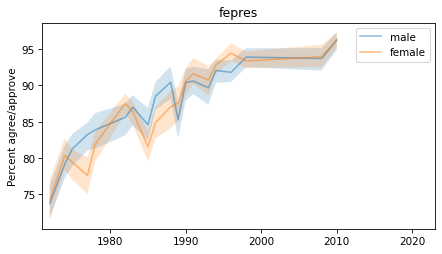

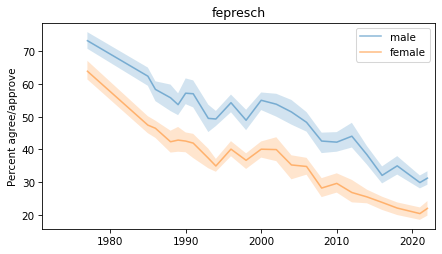

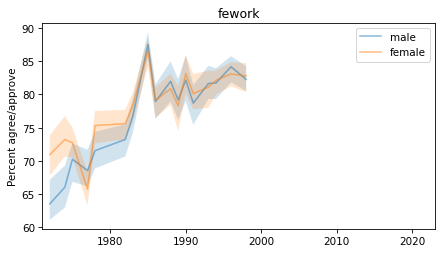

In [12]:
for column in fe_columns:
    plt.figure()
    plot_series_bounds(column, 'sex==1', 'sex==2')

## Young people

* Again, when we select people under 30, we have smaller sample sizes, so the series are noisier.

* For almost all questions, there is no statistically significant gender gap, no evidence of a growing gap, and no evidence of recent reversals that we can distinguish from noise.

* The only possible exceptions are `fehire` and `fejobaff` again, and maybe `fefam` (but I don't think any of them would survive statistical tests)

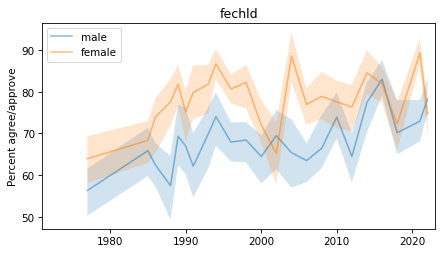

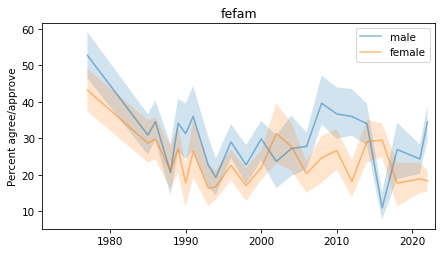

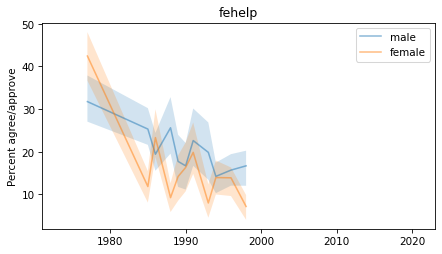

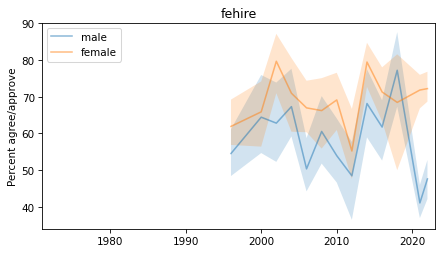

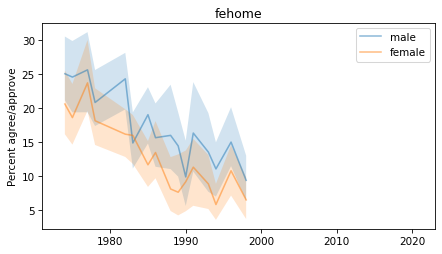

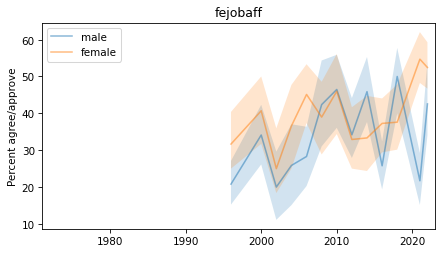

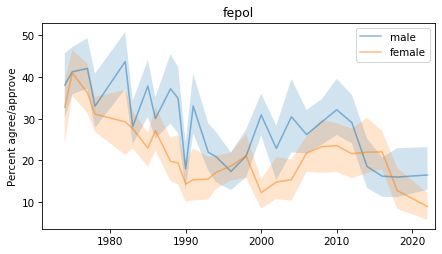

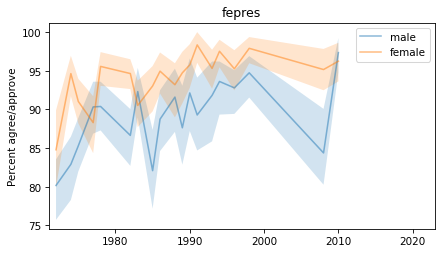

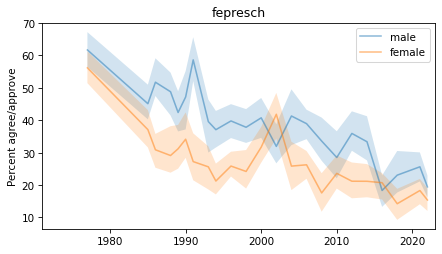

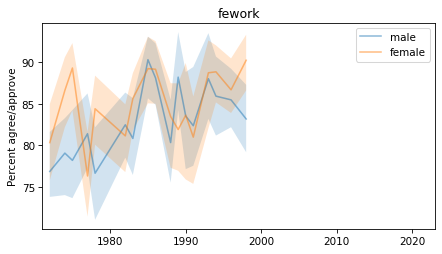

In [13]:
for column in fe_columns:
    plt.figure()
    plot_series_bounds(column, 'sex==1 & age<30', 'sex==2 & age<30')